$$Belman \quad Error = BE = \Delta_R  + \gamma \Delta_P W_{\phi} $$


Считаю, что $Ф = [U_1, r]$ 

in tabular case we need add extra column: reward, because otherwise reward_error will be very bad

# Что если ортогонализовать K(P, r)???
## Странности:
1. Бустится kry если его ортогонализовать
2. Формула в общем случае для вычисления Bellman Error is not valid, because F @ reward_A is not valid by shape
3. 



$\textbf{Case 1: Tabular raw features}$

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
n = 100
states = [i for i in range(n)]
transition_matrix_rank = 40

In [8]:
class mdp_low_rank():
    def __init__(self, A, A_next=None, reward=None, gamma=0.95, method="svd", P=None, r_start=10):
        self.A = A
        self.A_next = A_next
        self.n = A.shape[0]
        self.reward = reward
        if (self.reward is None):
            self.reward = np.random.random(self.n)
        self.num_iter = 10
        self.gamma = gamma
        self.BE = []
        self.epsilon = 1e-8
#        self.r_list = [i for i in range(10, self.n - 1)]
        self.r_list = [i for i in range(r_start, self.n + 1)]
        self.transition_matrix_rank = 40
        self.P = None
        self.method = method
        self.max_iter = 10
        self.states = np.arange(0, self.n)
        self.P = P
        if (self.A is not None and self.A_next is not None):
            self.P_A = np.linalg.pinv(self.A) @ self.A_next
        if (self.A is not None and self.reward is not None):
            self.reward_A = np.linalg.pinv(self.A) @ self.reward
        
        
    def check_transition_matrix(self, P):
        r = self.transition_matrix_rank
        assert(np.linalg.norm(P.sum(axis=1) - np.ones(P.shape[0])) < self.epsilon)

        U, S, V = np.linalg.svd(P, full_matrices=False)
        P = (U * S) @ V

        assert(np.linalg.norm(S[r:] - np.zeros(P.shape[0] - r)) < self.epsilon)

       
    def create_transition_matrix(self):
        
        tmp_matr1 = np.random.random((self.n, self.transition_matrix_rank))
        tmp_matr2 = np.random.random((self.transition_matrix_rank, self.n))
        P = tmp_matr1 @ tmp_matr2
        
        sum_rows = P.sum(axis=1)
        for j in range(n):
            P[j, :]  = P[j, :] / sum_rows[j]

        self.check_transition_matrix(P)
        
        return P
        
        
    @staticmethod 
    def sampling_states(P, size, init_state = None):
        """
        init_states
        return list of sampled states
        states in {0, ... , n}
        """
        
        states_list = []
        if (init_state == None):
            init_states = np.random.choice(self.states)
            
        cur_state = init_state
            
        for i in range(size):
            p = P[cur_state]
            next_state = np.random.choice(self.states, size=1, p=p)
            states_list.append(next_state)
            cur_state = next_state
            
            
        return states_list

     
    
    def choose_feature_matrix(self, method, r):
        if (method == "svd"):
            U, S, V = np.linalg.svd(self.P, full_matrices=True)
#           F = np.c_[U[:, :r] @ np.diag(S)[:r, :r], self.reward]
            F = np.c_[U[:, :r] @ np.diag(S)[:r, :r], self.reward]
        elif (method == "eig-r"):
            w, vr = np.linalg.eig(self.P)
            F = np.c_[vr[:, :r], self.reward]
        elif (method == "kry"): 
            F = np.zeros((self.n, r))
            F[:, 0] = self.reward
            for k in range(1, r):
                F[:, k] = self.P @ F[:, k - 1]
            F, _ = np.linalg.qr(F) # cheat sheet
        elif (method == "lfd"):
            D = np.random.rand(r, A.shape[1])
            E = np.random.rand(A.shape[1], r)
            diff, i = np.inf, 0
            while (np.linalg.norm(E @ D - A) < diff and i < self.max_iter):
                diff = np.linalg.norm(E @ D - A)
                E = A @ np.linalg.pinv(D)
                D = np.linalg.pinv(E) @ A
                i += 1
            return E

            
        else:
            raise ValueError("This method is not implemented")
        
        
        return F
        
    def get_approx_transition_matrix(self):
        if (self.P_A is None):
            self.P_A = np.linalg.pinv(self.A) @ self.A_next
            
        return self.P_A
    
    
    def get_approx_reward(self):
        if (self.reward_A is None):
            self.reward_A = np.linalg.pinv(self.A) @ self.reward
            
        return self.reward_A
 

    def get_approx_feature_matrix(self, method, r):
        if (self.method == "svd"):
            P_A = self.get_approx_transition_matrix()
            reward_A = self.get_approx_reward()
            U, S, V = np.linalg.svd(P_A, full_matrices=True)
            F = np.c_[U[:l, :(r - 1)] @ np.diag(S)[:(r - 1), :(r - 1)], reward_A]           
            
#            import pdb; pdb.set_trace();
#            pdb.set_trace()
            
            
            return self.A @ F, F
#           return F
        
        elif (method == "kry"): 
            F = np.zeros((self.n, r))
            F[:, 0] = self.reward
            for k in range(1, r):
                F[:, k] = self.P @ F[:, k - 1]
            F, _ = np.linalg.qr(F) # cheat sheet
#            reward_A = 
            
            return self.A @ F, F
        
        
   
    
    def calculate_BE(self, r, method):
        if (method == "tabular"):
            F = self.choose_feature_matrix(method=self.method, r=r)
            P_F = np.linalg.pinv(F) @ self.P @ F
            reward_F = np.linalg.pinv(F) @ self.reward
            w_F = np.linalg.pinv(np.eye(P_F.shape[0]) - self.gamma * P_F) @ reward_F
            reward_error = np.linalg.norm(self.reward - F @ reward_F)
            transition_error = np.linalg.norm(self.P @ F - F @ P_F)
            all_error = np.linalg.norm((self.reward - F @ reward_F) + self.gamma * (self.P @ F - F @ P_F) @ w_F)
        elif (method == "approx"):
            F, F_hat = self.get_approx_feature_matrix(method=self.method, r=r)
            P_F = np.linalg.pinv(F) @ self.P_A @ F
#            P_F = np.linalg.pinv(F_hat) @ self.P_A @ F_hat ## smth strange
#            reward_F = np.linalg.pinv(F) @ self.reward_A ## smth strange
#            reward_F = np.linalg.pinv(F_hat) @ self.reward_A 
            reward_F = np.linalg.pinv(F) @ self.reward_A 
            w_F = np.linalg.pinv(np.eye(P_F.shape[0]) - self.gamma * P_F) @ reward_F
            reward_error = np.linalg.norm(self.reward - F @ reward_F)
            transition_error = np.linalg.norm(self.P @ F - F @ P_F)
            all_error = np.linalg.norm((self.reward - F @ reward_F) + self.gamma * (self.P @ F - F @ P_F) @ w_F)
        
        
        return all_error
    

    def calculate_BE_list(self, method="tabular"):
        
            
        if (method == "tabular"):
            self.P = self.create_transition_matrix()
            for r in self.r_list:
                self.BE.append(self.calculate_BE(r, method=method))

            return self.BE, self.r_list
        
        if (method == "approx"):
            if (self.A is None or self.A_next is None or self.reward is None or self.P is None):
                raise ValueError("This method is not supported!")
                
            for r in self.r_list:
                self.BE.append(self.calculate_BE(r, method=method))

            return self.BE, self.r_list

                
        

In [9]:
n = 100 # size of observed states
l = 50  # size of features for every state

# A = np.eye(n)
A = np.random.binomial(n=1, p=0.5, size=(n, n))
mdp = mdp_low_rank(A=A, method="eig-r", r_start=1)
BE_eig_r, r_list = mdp.calculate_BE_list()
mdp = mdp_low_rank(A=A, method="kry", r_start=1)
BE_kry, r_list = mdp.calculate_BE_list()
mdp = mdp_low_rank(A=A, method="svd", r_start=1)
BE_svd, r_list = mdp.calculate_BE_list()
mdp = mdp_low_rank(A=A, method="lfd", r_start=1)
BE_lfd, r_list = mdp.calculate_BE_list()

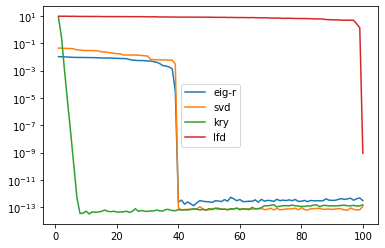

In [10]:
plt.semilogy(r_list, BE_eig_r, label="eig-r")
plt.semilogy(r_list, BE_svd, label="svd")
plt.semilogy(r_list, BE_kry, label="kry")
plt.semilogy(r_list, BE_lfd, label="lfd")
plt.legend()


$\textbf{Case 2: Image-based raw features}$

In [11]:
def sampling_states(P, size, init_state = None):
    """
    init_states
    return list of sampled states
    states in {0, ... , n}
    """

    states_list = []
    if (init_state == None):
#        import pdb; pdb.set_trace()
        init_state = np.random.choice(states)

    cur_state = init_state

    for i in range(size):
        p = P[cur_state, :]
        next_state = np.random.choice(states, size=1, p=p)[0]
        states_list.append(next_state)
        cur_state = next_state


    return states_list



def check_transition_matrix(P, transition_matrix_rank):
    epsilon = 1e-6
    r = transition_matrix_rank
    assert(np.linalg.norm(P.sum(axis=1) - np.ones(P.shape[0])) < epsilon)

    U, S, V = np.linalg.svd(P, full_matrices=False)
    P = (U * S) @ V

    assert(np.linalg.norm(S[r:] - np.zeros(P.shape[0] - r)) < epsilon)

    return 



def get_transition_matrix(transition_matrix_rank, n):
    tmp_matr1 = np.random.random((n, transition_matrix_rank))
    tmp_matr2 = np.random.random((transition_matrix_rank, n))
    P = tmp_matr1 @ tmp_matr2

    sum_rows = P.sum(axis=1)
    for j in range(n):
        P[j, :]  = P[j, :] / sum_rows[j]

    check_transition_matrix(P, transition_matrix_rank)
    
    return P



def create_raw_features(n=100, l=50, transition_matrix_rank=40):
    states = [i for i in range(n)]
    P = get_transition_matrix(transition_matrix_rank, n)
    A = np.zeros((n, l))
    A_next = np.zeros((n, l))
    state_to_vec = dict()
    for state in states:
        state_to_vec[state] = np.random.binomial(n=1, p=0.5, size=l)
    sampled_states = sampling_states(P=P, size=n+1)
#    print(sampled_states)
    for i in range(len(sampled_states) - 1):
        A[i, :] = state_to_vec[sampled_states[i]]
        A_next[i, :] = state_to_vec[sampled_states[i + 1]]
    
    reward = np.random.random(A.shape[0])

    return A, A_next, P, reward

In [12]:
#A, A_next, P, reward = create_raw_features()
#P_A = np.linalg.pinv(A) @ A_next

In [ ]:
A, A_next, P, reward = create_raw_features()
print(A.shape)
print(A_next.shape)
mdp = mdp_low_rank(A=A, A_next=A_next, P=P, reward=reward, method="svd", r_start=10)
%debug
BE_svd, r_list = mdp.calculate_BE_list(method="approx")
print("svd")
#mdp = mdp_low_rank(A=A, A_next=A_next, P=P, reward=reward, method="kry", r_start=10)
#%debug
#BE_svd, r_list = mdp.calculate_BE_list(method="approx")
#print("kry")
#mdp = mdp_low_rank(A=A, method="kry")
#BE_kry, r_list = mdp.calculate_BE_list()
#print("kry")
#mdp = mdp_low_rank(A=A, method="svd")
#BE_svd, r_list = mdp.calculate_BE_list()
#print("svd")
#mdp = mdp_low_rank(A=A, method="lfd")
#BE_lfd, r_list = mdp.calculate_BE_list()
#print("lfd")

(100, 50)
(100, 50)
> <ipython-input-8-b6bebc85314e>(161)calculate_BE()
    159         elif (method == "approx"):
    160             F, F_hat = self.get_approx_feature_matrix(method=self.method, r=r)
--> 161             P_F = np.linalg.pinv(F) @ self.P_A @ F
    162 #            P_F = np.linalg.pinv(F_hat) @ self.P_A @ F_hat ## smth strange
    163 #            reward_F = np.linalg.pinv(F) @ self.reward_A ## smth strange

ipdb> F.shape
(100, 10)
ipdb> F_hat.shape
(50, 10)
ipdb> A.shape
(100, 50)
ipdb> self.P_A.shape
(50, 50)
ipdb> F.shape
(100, 10)


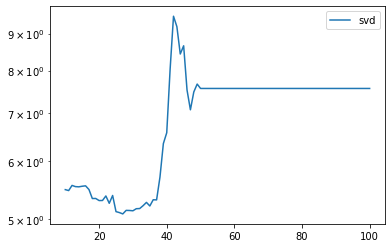

In [97]:
#plt.semilogy(r_list, BE_eig_r, label="eig-r")
plt.semilogy(r_list, BE_svd, label="svd")
#plt.semilogy(r_list, BE_kry, label="kry")
#plt.semilogy(r_list, BE_lfd, label="lfd")
plt.legend()
